In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
a     = 1  # well is -a to +a
v     = -3 # depth of well in units of E1
min_n = np.sqrt(np.abs(v))
print("Minimum n:  ", min_n)
n=2.2

Minimum n:   1.7320508075688772


In [3]:
# peicewise definition of psi:
def psi_pw(x, eta, k, A, zsin, phi):
    sqrtT = 1/np.sqrt(1+zsin**2)        
    if (x<-a):
        return A*np.exp(1j*k*(x+a))+1j*A*zsin*sqrtT*np.exp(1j*phi)*np.exp(-1j*k*(x+a))
    if (x>a):
        return A*sqrtT*np.exp(1j*(k*(x-a)+phi))
    else:
        return A*sqrtT*np.exp(1j*phi)*(cos(eta*k*(x-a)) + 1j*sin(eta*k*(x-a))/eta)

def ref_pw(x, eta, k, A, zsin, phi):
    sqrtT = 1/np.sqrt(1+zsin**2)        
    if (x<-a):
        return +1j*A*zsin*sqrtT*np.exp(1j*phi)*np.exp(-1j*k*(x+a))
    return 0
    
psi_pwv = np.vectorize(psi_pw)
ref_pwv = np.vectorize(ref_pw)

def psi(x,n):
    A = 1
    eta = np.sqrt(1+v/n**2)
    k = n * pi / (2*a*eta)
    z = (eta**2-1)/(2*eta)
    cos_theta=np.cos(2*eta*k*a)
    sin_theta=np.sin(2*eta*k*a)
    zsin = z*sin_theta
    phi = np.arctan2(sqrt(z**2+1)*sin_theta,cos_theta)
    return psi_pwv(x,eta,k,A,zsin,phi)

def tpsi(x,t,n):
    phi = (8/pi**2)*(n**2-v)*t
    return psi(x,n)*np.exp(-1j*phi)

def ppsi(x,phi,n):
    return psi(x,n)*np.exp(-1j*phi)



def ref(x,n):
    A = 1
    eta = np.sqrt(1+v/n**2)
    k = n * pi / (2*a*eta)
    z = (eta**2-1)/(2*eta)
    cos_theta=np.cos(2*eta*k*a)
    sin_theta=np.sin(2*eta*k*a)
    zsin = z*sin_theta
    phi = np.arctan2(sqrt(z**2+1)*sin_theta,cos_theta)
    return ref_pwv(x,eta,k,A,zsin,phi)

def tref(x,t,n):
    phi = (8/pi**2)*(n**2-v)*t
    return ref(x,n)*np.exp(-1j*phi)

def pref(x,phi,n):
    return ref(x,n)*np.exp(-1j*phi)







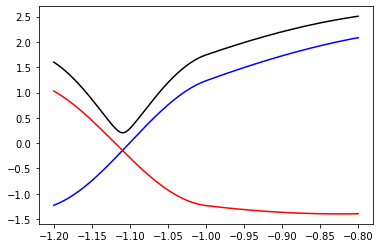

In [4]:
n=1.78
t=0.2
x = np.linspace(-1.2,-0.8,2000)
plot(x,tpsi(x,t,n).real,"b-")
plot(x,tpsi(x,t,n).imag,"r-")
plot(x,np.absolute(tpsi(x,t,n)),"k-")

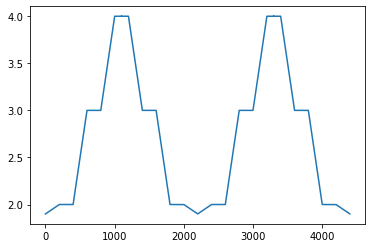

In [5]:
def get_n(i):
    i = i%2200
    nmin = 1.9
    na   = 2
    nb   = 3
    nc   = 4
    if (i<200):
        return nmin + (na-nmin)*i/200
    if (i>=200) and (i<400):
        return na
    if (i>=400) and (i<600):
        return na + (nb-na)*(i-400)/200
    if (i>=600) and (i<800):
        return nb
    if (i>=800) and (i<1000):
        return nb + (nc-nb)*(i-800)/200
    if (i>=1000) and (i<1100):
        return nc
    if (i>1100) and (i<2200):
        return get_n(2*1100-i)
    
nv = np.vectorize(get_n)

x = np.arange(4400)
plt.plot(x,nv(x))

In [6]:
# Move in and out of resonance

file_name = "resonance"
total_frames = 2200
scene_i = 0
xf    =0
psif  =0
reff  =0
text_a=0
text_b=0
text_c=0
show_legend=True
show_real=True
show_imag=True
tstep = 0.01
phi   = 0  # accumulate phi since we will be moving energy around

def init_scenes(ax):
    global xf
    global text_a, text_b, text_c
    ax .set_xlim (-3,3)
    ax .set_ylim (-3,3)
    ax .set_xlabel("$x$")
    ax .set_ylabel("$\psi(x)$")
    ax .set_title("Square Well Potential")
    xf = np.linspace(-3,3,1000)
    # constant text:
    plt.text(0.01, 0.95, r"$a = 1$,", transform = ax.transAxes, horizontalalignment='left')
    plt.text(0.16, 0.95, r"$\tau = m a^2 /\hbar$", transform = ax.transAxes, horizontalalignment='left')
    plt.text(0.01, 0.85, r"$V_0/E_1 = {}$,".format(v), transform = ax.transAxes, horizontalalignment='left')    
    plt.text(0.01, 0.02, r"1 second = {} $\tau$".format(np.round(second_tau,2)), transform = ax.transAxes, horizontalalignment='left')
    plt.text(0.98, 0.02, 'Mulhearn UC Davis',transform = ax.transAxes, horizontalalignment='right')
    # dynamic text:
    text_a = plt.text(0, 0, "")
    text_b = plt.text(0, 0, "")
    text_c = plt.text(0, 0, "")
    text_a.set_visible(False)
    text_b.set_visible(False)
    text_c.set_visible(False)    
        
def update_scene(i):
    global text_a, text_b, text_c
    global scene_i
    global phi,psif,reff
    text_a.set_visible(False)
    scene_i = scene_i + 1
    #text_a = plt.text(0.5, 0.05, r"$t/\tau = {}$".format(np.round(scene_i*tstep,1)), transform = ax.transAxes, horizontalalignment='center')    
    n = get_n(i)
    text_a = plt.text(0.4, 0.05, r"$(E+V_0)/E_1 = {}$".format(np.round(n,2)), transform = ax.transAxes, horizontalalignment='left')
    phi = phi + (8/pi**2)*(n**2-v)*tstep
    psif = ppsi(xf,phi,n)
    reff = pref(xf,phi,n)

<IPython.core.display.Javascript object>


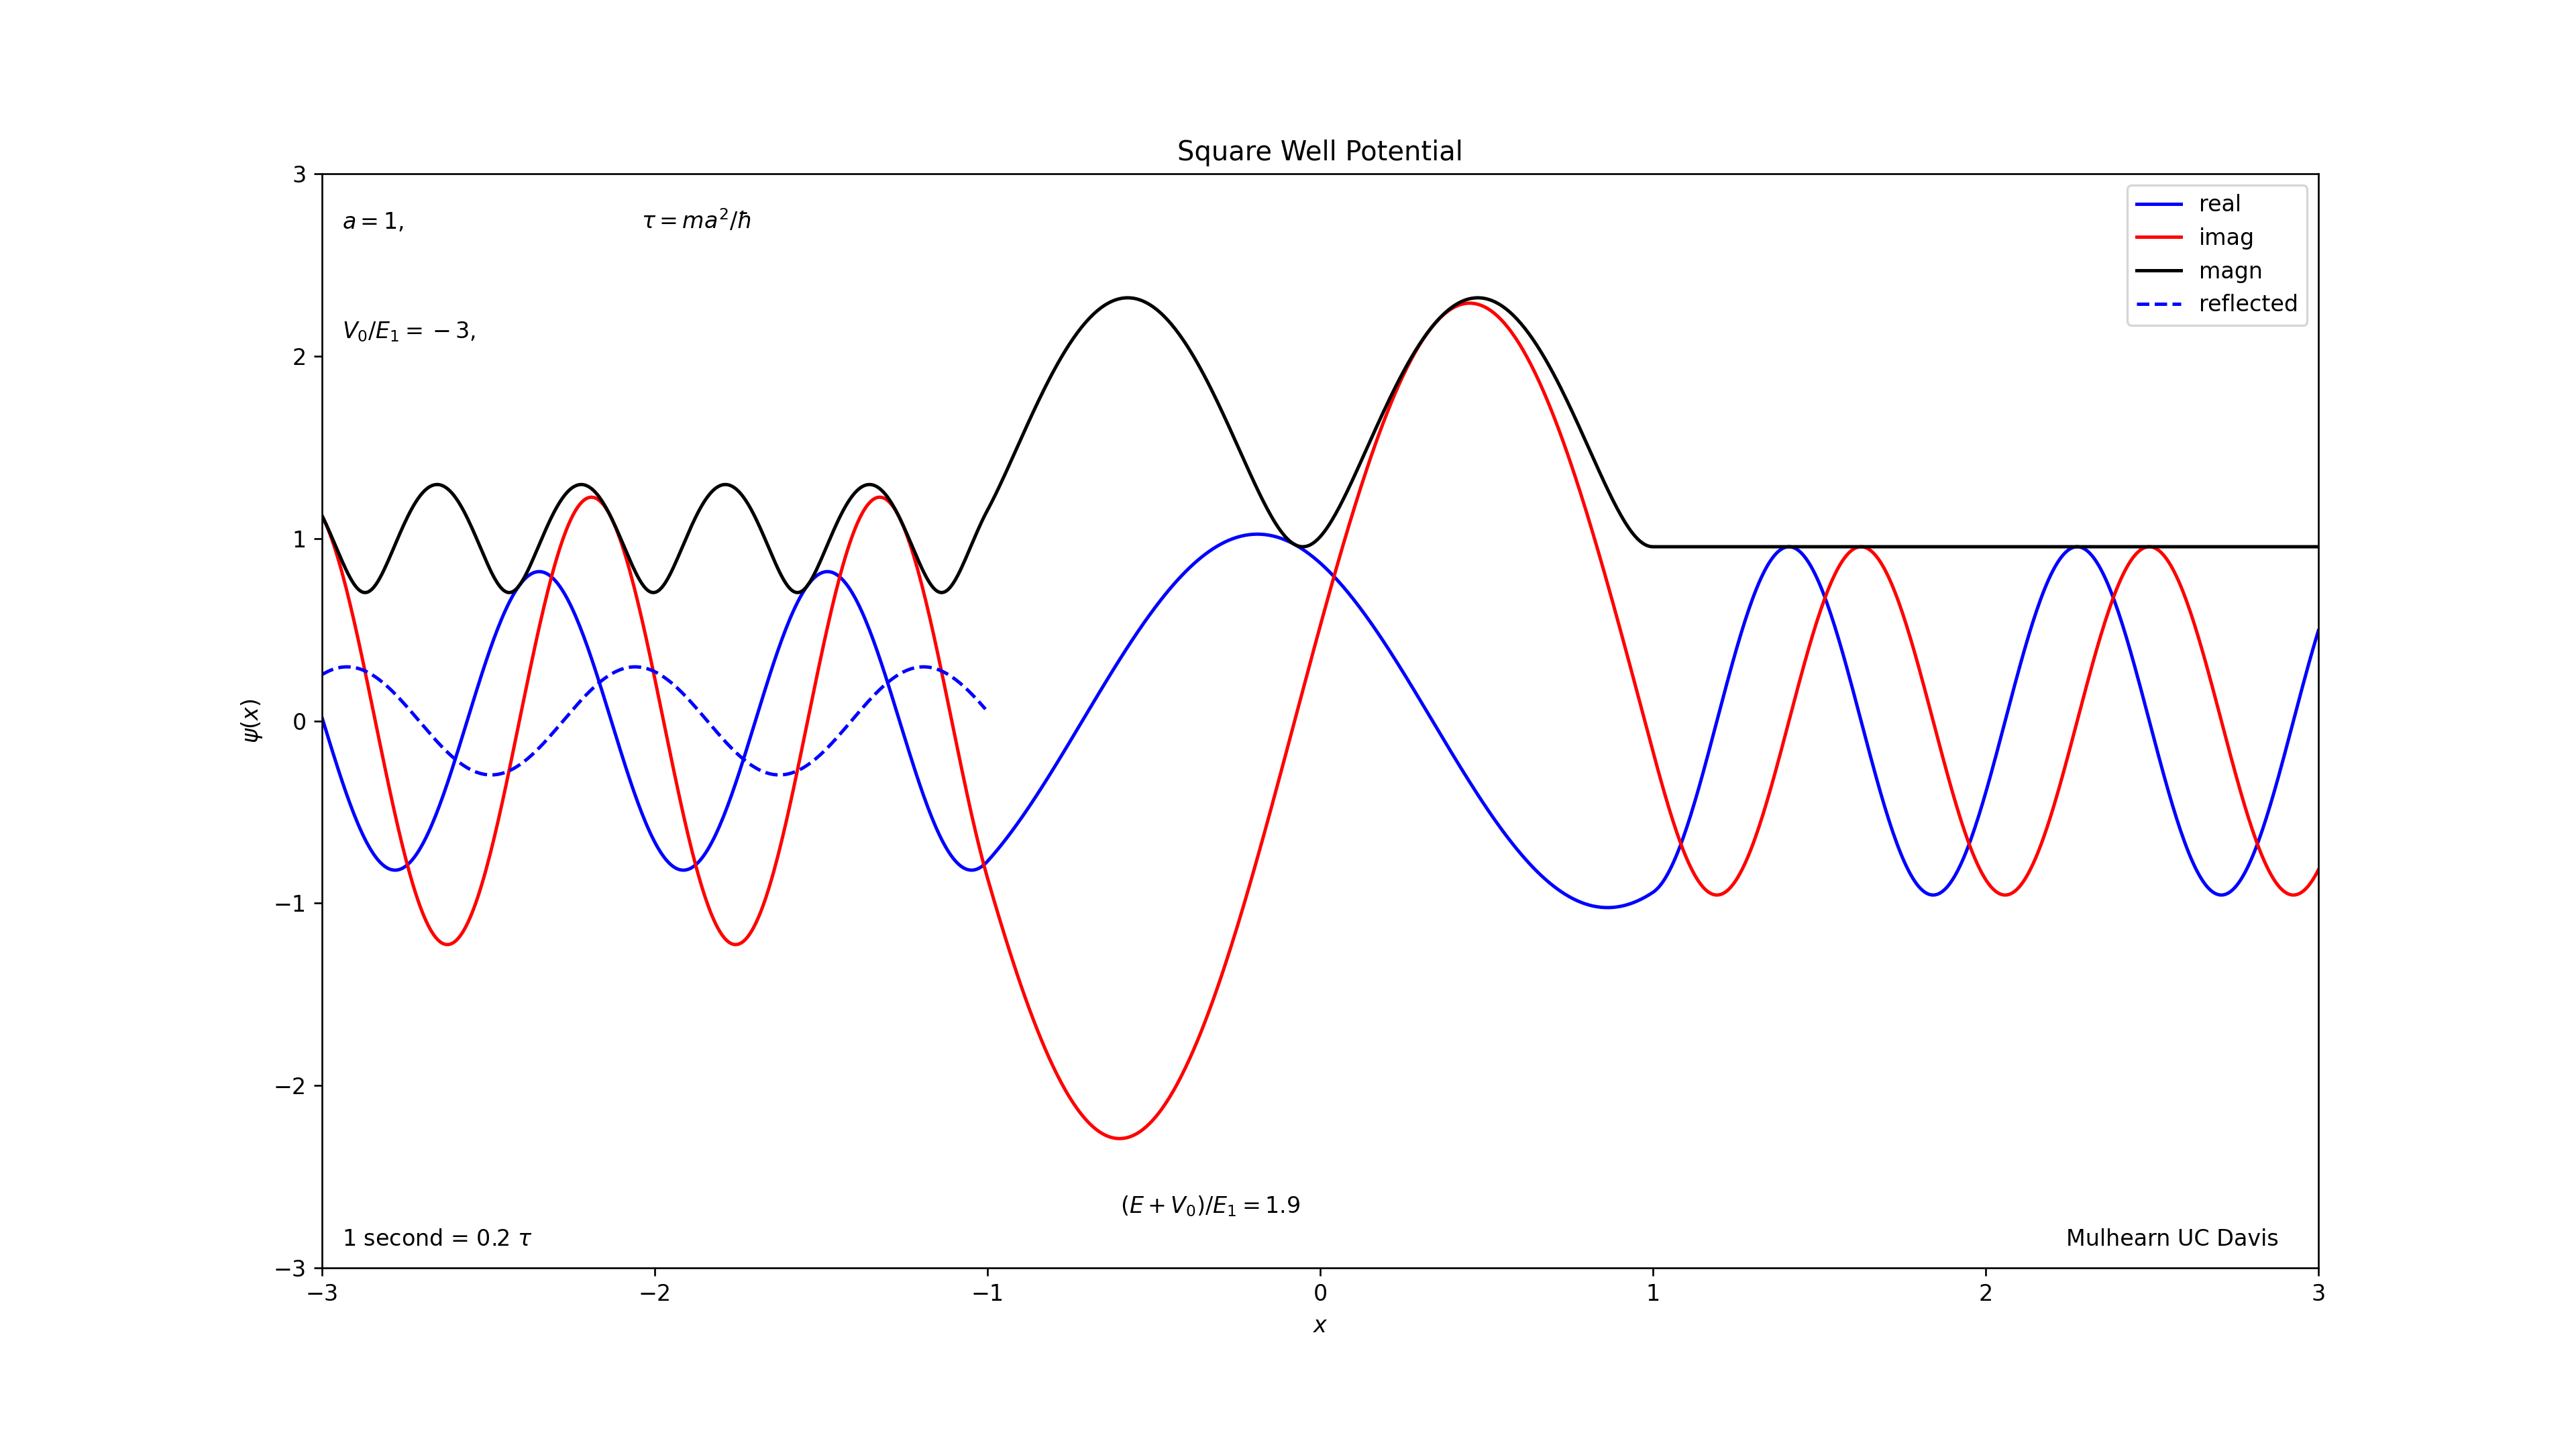

TypeError: unsupported operand type(s) for *: 'NoneType' and 'float'

In [7]:
%matplotlib notebook
from matplotlib.animation import FuncAnimation
from matplotlib.animation import writers

#WRITE_MP4 = False
WRITE_MP4 = True

# The frames per second is accurate when writing an mp3 file,
# but when just showing the animation the timing can lag.
#tstep     = 1
fps       = 20
frame_ms  = 1000/fps
second_tau = fps*tstep

#uncomment for full resolution video:
if (WRITE_MP4):
    fig = plt.figure(figsize=(16, 9), dpi=(1920/16))

ax = plt.gca()  # Get current axes
la , = ax. plot ([], [], "b-",label="real")
lb , = ax. plot ([], [], "r-",label="imag")
lc , = ax. plot ([], [], "k-",label="magn")
ld , = ax. plot ([], [], "b--",label="reflected")

init_scenes(ax)

def animate (i):
    update_scene(i)
    la. set_data (xf,np.real(psif))
    lb. set_data (xf,np.imag(psif))
    lc. set_data (xf,np.absolute(psif))    
    ld. set_data (xf[xf<-a],np.real(reff[xf<-a]))    
    plt.legend()
    ax.legend().set_visible(show_legend)
    la. set_visible(show_real)
    lb. set_visible(show_imag)
    

anim = FuncAnimation (plt .gcf () , animate , frames =total_frames , interval =20 , repeat = False )
    
# Set up formatting for the movie files
if (WRITE_MP4):
    Writer = writers['ffmpeg']
    writer = Writer(fps=fps, metadata=dict(artist='Mulhearn'), bitrate=3600)
    anim.save(file_name+".mp4", writer=writer)
